In [11]:
import os
import os.path as osp
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 

import sys
sys.path.append('../')

from layers.cost_volume import CostVolume
from layers.hdc_functions import hdc_resnet_group
from layers.residual_blocks import PreactBasicResidualBlock, ResidualBlock, resnet_shortcut
from layers.residual_blocks import preact_resnet_group
from layers.matchability import Matchability
from layers.soft_argmin import SoftArgmin
from layers.transition_blocks import TransitionBlock

In [13]:
class LeakyPreactBasicResidualBlock(ResidualBlock):
    """Pre-activation basic residual block."""

    def __init__(self, in_channels, base_channels, stride=1, dilation_rate=1,
                 add_preact=True, add_last_norm=False):
        """
        Args:
            in_channels (int): The number of input channels.
            base_channels (int): The number of output channels.
            stride (int, optional): Stride of the residual block.
            dilation_rate (int, optional): Dilation rate of the residual block.
            add_preact (bool, optional): If True, add pre-activation.
            add_last_norm (bool, optional): If True, add batch normalization
                                            after the last convolution.
        """
        super().__init__()
        if add_preact:
            self.preact_bn = nn.BatchNorm2d(in_channels)
        else:
            self.preact_bn = None
        self.conv_shortcut = resnet_shortcut(in_channels, base_channels, stride, preact=True)
        self.conv1 = nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=stride, padding=dilation_rate,
                               dilation=dilation_rate, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.LeakyReLU(inplace=True, negative_slope=0.1)
        self.conv2 = nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=dilation_rate,
                               dilation=dilation_rate, bias=False)
        self.bn_last = nn.BatchNorm2d(base_channels) if add_last_norm else None

    @classmethod
    def expansion(cls):
        """Expansion rate, which is a ratio of the number of the output
        channels to the number of the base channels in the residual block.

        Returns:
            Expansion rate (= 1).
        """
        return 1

    @classmethod
    def preact(cls):
        """Pre-activation flag.

        Returns:
            Flag (= True).
        """
        return True

    def forward(self, inputs):
        """Forward computation.

        Args:
            inputs (Tensor): Input tensor.

        Returns:
            Output tensor.
        """
        if self.conv_shortcut is None:
            shortcut_inputs = inputs
        else:
            shortcut_inputs = self.conv_shortcut(inputs)

        if self.preact_bn is not None:
            inputs = self.relu(self.preact_bn(inputs))
        outputs = self.relu(self.bn1(self.conv1(inputs)))
        outputs = self.conv2(outputs)

        outputs += shortcut_inputs

        if self.bn_last is not None:
            outputs = self.relu(self.bn_last(outputs))
        return outputs

In [14]:
class HybridDilatedResNetAlpha(nn.Module):
    """First feature extractor stage"""

    def __init__(self, num_blocks, num_channels, dilation_rates):
        super().__init__()
        assert len(num_blocks) == 3
        assert len(num_channels) == 3

        block_func = PreactBasicResidualBlock

        self.transition1 = TransitionBlock(3, num_channels[0], 2)

        self.transition2 = TransitionBlock(num_channels[0], num_channels[0], 2)
        self.group1 = preact_resnet_group(block_func, num_channels[0], num_channels[0], num_blocks[0])

        self.transition3 = TransitionBlock(num_channels[0], num_channels[1], 2)
        self.group2 = preact_resnet_group(block_func, num_channels[1], num_channels[1], num_blocks[1])

        self.transition4 = TransitionBlock(num_channels[1], num_channels[2], 2)
        self.group3 = hdc_resnet_group(block_func, num_channels[2], num_channels[2], num_blocks[2],
                                       dilation_rates=dilation_rates)

    def forward(self, inputs):
        outputs = self.transition1(inputs)
        outputs = self.transition2(outputs)
        group1_outputs = self.group1(outputs)
        outputs = self.transition3(group1_outputs)
        group2_outputs = self.group2(outputs)
        outputs = self.transition4(group2_outputs)
        group3_outputs = self.group3(outputs)

        return group1_outputs, group2_outputs, group3_outputs

In [15]:
def hdrn_alpha_base(num_channels):
    return HybridDilatedResNetAlpha(num_blocks=[3, 4, 8],
                                    num_channels=[num_channels, num_channels * 2, num_channels * 4],
                                    dilation_rates=[1, 2, 5, 9])

In [16]:
class ScoreFeatures(nn.Module):
    """Generate output features for the from the differente scales of features maps from feature extractor"""

    def __init__(self, in_channels, out_channels, out_scale):
        super().__init__()
        assert out_scale in [4, 8, 16]

        self.score_16x = nn.Conv2d(in_channels * 4, out_channels, kernel_size=1, bias=True)
        if out_scale <= 8:
            self.score_8x = nn.Conv2d(in_channels * 2, out_channels, kernel_size=1, bias=True)
        else:
            self.score_8x = None
        if out_scale <= 4:
            self.score_4x = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True)
        else:
            self.score_4x = None

        self.upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

    def forward(self, features_4x, features_8x, features_16x):
        output = self.score_16x(features_16x)
        if self.score_8x is not None:
            output = self.score_8x(features_8x) + self.upsample2(output)
        if self.score_4x is not None:
            output = self.score_4x(features_4x) + self.upsample2(output)
        return output


class RefineInBlock(nn.Module):
    """Process disparity, matchability, and cost volume inputs for disparity refinement stage"""

    def __init__(self, num_disparities, out_channels, in_scale, out_scale):
        super().__init__()

        scale_factor = in_scale / out_scale
        self.resize = nn.Upsample(scale_factor=scale_factor, mode="bilinear", align_corners=True)

        self.disp_block1 = PreactBasicResidualBlock(2, out_channels // 2, add_preact=False, add_last_norm=False)
        self.disp_block2 = PreactBasicResidualBlock(out_channels // 2, out_channels, add_preact=True,
                                                    add_last_norm=True)
        self.out_block1 = PreactBasicResidualBlock(out_channels, out_channels, add_preact=False, add_last_norm=False)
        self.out_block2 = PreactBasicResidualBlock(out_channels, out_channels, add_preact=True, add_last_norm=True)

    def forward(self, disparity, matchability, _):
        # Process disparity/matchability inputs.
        disp_inputs = self.disp_block1(torch.cat([disparity, matchability], dim=1))
        disp_inputs = self.disp_block2(disp_inputs)

        # Merge processed disparity inputs.
        outputs = disp_inputs
        outputs = self.resize(outputs)
        outputs = self.out_block1(outputs)
        outputs = self.out_block2(outputs)
        return outputs

In [17]:
class UpsampleBlock(nn.Module):
    """Upsample with bilinear interpolation followed by a 3x3 convolution"""

    def __init__(self, in_features, out_features):
        super().__init__()

        self.conv = nn.Conv2d(in_features, out_features, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_features)
        self.relu = nn.LeakyReLU(inplace=True, negative_slope=0.1)

        self.upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

    def forward(self, features: torch.Tensor, new_features: Optional[torch.Tensor]):
        outputs = self.conv(self.upsample2(features))
        if new_features is not None:
            outputs += new_features
        return self.relu(self.bn(outputs))


class HybridDilatedResNetAlphaRefine(nn.Module):
    """Refinement to generate full resolution disparity given a left image and low resolution disparity outputs"""

    def __init__(self, num_disparities, in_scale, num_blocks, num_channels, dilation_rates):
        super().__init__()
        assert len(num_blocks) == 3
        assert len(num_channels) == 3

        block_func = PreactBasicResidualBlock

        self.in_scale = in_scale
        self.disp_block = RefineInBlock(num_disparities, num_channels[0], in_scale, 4)

        self.block_merge1 = PreactBasicResidualBlock(num_channels[0] * 2, num_channels[0] * 2, stride=1,
                                                     add_preact=False, add_last_norm=False)
        self.block_merge2 = PreactBasicResidualBlock(num_channels[0] * 2, num_channels[0], stride=1, add_preact=True,
                                                     add_last_norm=True)

        self.transition1 = TransitionBlock(3, num_channels[0], 2)

        self.transition2 = TransitionBlock(num_channels[0], num_channels[0], 2)
        self.group1 = preact_resnet_group(block_func, num_channels[0], num_channels[0], num_blocks[0])

        self.transition3 = TransitionBlock(num_channels[0], num_channels[1], 2)
        self.group2 = preact_resnet_group(block_func, num_channels[1], num_channels[1], num_blocks[1])

        self.transition4 = TransitionBlock(num_channels[1], num_channels[2], 2)
        self.group3 = hdc_resnet_group(block_func, num_channels[2], num_channels[2], num_blocks[2],
                                       dilation_rates=dilation_rates)

        offset_channels = 8
        self.group1_output = nn.Conv2d(num_channels[0], offset_channels * 2, kernel_size=3, padding=1)
        self.group2_output = nn.Conv2d(num_channels[1], offset_channels * 4, kernel_size=3, padding=1)
        self.group3_output = nn.Conv2d(num_channels[2], offset_channels * 8 - 1, kernel_size=3, padding=1)

        self.up_8x = UpsampleBlock(offset_channels * 8, offset_channels * 4)
        self.up_4x = UpsampleBlock(offset_channels * 4, offset_channels * 2)
        self.up_2x = UpsampleBlock(offset_channels * 2, offset_channels - 1)

        self.base_upsample = nn.Upsample(scale_factor=self.in_scale, mode='bilinear', align_corners=False)
        self.base_downsample = nn.MaxPool2d(kernel_size=16 // self.in_scale)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.conv_out = nn.Conv2d(offset_channels, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, image, disparity, matchability, cost_volume):
        base_disparity = self.base_upsample(disparity) * self.in_scale

        disp_input = self.disp_block(disparity, matchability, cost_volume)

        outputs = self.transition1(image)
        outputs = self.transition2(outputs)

        outputs = torch.cat([outputs, disp_input], dim=1)
        outputs = self.block_merge1(outputs)
        outputs = self.block_merge2(outputs)

        outputs = self.group1(outputs)
        group1_outputs = self.group1_output(outputs)
        outputs = self.transition3(outputs)
        outputs = self.group2(outputs)
        group2_outputs = self.group2_output(outputs)
        outputs = self.transition4(outputs)
        outputs = self.group3(outputs)
        group3_outputs = self.group3_output(outputs)

        outputs = torch.cat([self.base_downsample(disparity) / (16 // self.in_scale), group3_outputs], dim=1)
        outputs = self.up_8x(outputs, group2_outputs)
        outputs = self.up_4x(outputs, group1_outputs)
        outputs = self.up_2x(outputs, None)

        outputs = self.conv_out(torch.cat([base_disparity, self.upsample2(outputs)], dim=1))

        return self.relu(base_disparity + outputs)

In [18]:
def hdrn_alpha_base_refine(num_disparities, in_scale):
    return HybridDilatedResNetAlphaRefine(num_disparities, in_scale, num_blocks=[3, 4, 8], num_channels=[32, 64, 128],
                                          dilation_rates=[1, 2, 5, 9])

In [19]:
class PcvBlock3d(nn.Module):
    """Block for processing cost volume using 3D convolutions"""

    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(mid_channels)
        self.relu = nn.LeakyReLU(inplace=True, negative_slope=0.1)
        self.conv2 = nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, inputs):
        outputs = self.relu(self.bn1(self.conv1(inputs)))
        outputs = self.relu(self.bn2(self.conv2(outputs)))
        return outputs

In [20]:
class ProcessCostVolume(nn.Module):
    """Process cost volume and prepare for soft argmin operation"""

    def __init__(self, in_channels, channels_3d, num_disparities):
        super().__init__()

        self.block3d = PcvBlock3d(in_channels, in_channels // 2, channels_3d)

        channels_2d = channels_3d * num_disparities
        assert (channels_2d // 4) >= num_disparities
        self.flatten = nn.Flatten(1, 2)
        self.block2d_1 = LeakyPreactBasicResidualBlock(channels_2d, channels_2d, stride=1, dilation_rate=1,
                                                       add_preact=False, add_last_norm=False)
        self.block2d_2 = LeakyPreactBasicResidualBlock(channels_2d, channels_2d // 2, stride=1, dilation_rate=2,
                                                       add_preact=True, add_last_norm=False)
        self.block2d_3 = LeakyPreactBasicResidualBlock(channels_2d // 2, channels_2d // 4, stride=1, dilation_rate=5,
                                                       add_preact=True, add_last_norm=False)
        self.block2d_4 = LeakyPreactBasicResidualBlock(channels_2d // 4, num_disparities, stride=1, dilation_rate=9,
                                                       add_preact=True, add_last_norm=True)

        self.conv_out = nn.Conv2d(num_disparities, num_disparities, kernel_size=1, bias=True)

    def forward(self, inputs):
        outputs = self.block3d(inputs)

        outputs = self.flatten(outputs)
        outputs = self.block2d_1(outputs)
        outputs = self.block2d_2(outputs)
        outputs = self.block2d_3(outputs)
        outputs = self.block2d_4(outputs)
        outputs = self.conv_out(outputs)

        return outputs

In [21]:
class HdrnAlphaStereo(nn.Module):

    def __init__(self, hparams):
        super().__init__()

        self.num_disparities = hparams.num_disparities
        self.internal_scale = hparams.downsample_factor
        self.internal_num_disparities = self.num_disparities // self.internal_scale
        assert self.internal_scale in [4, 8, 16]

        self.max_disparity_small = self.internal_num_disparities - 1
        self.max_disparity = self.max_disparity_small * self.internal_scale - 1

        self.features = hdrn_alpha_base(hparams.fe_internal_features)
        self.score_features = ScoreFeatures(hparams.fe_internal_features, hparams.fe_features, self.internal_scale)

        self.cost_volume = CostVolume(self.internal_num_disparities)
        self.process_cost_volume = ProcessCostVolume(hparams.fe_features, 4, self.internal_num_disparities)

        self.soft_argmin = SoftArgmin()
        self.matchability = Matchability()

        self.disparity_refinement = hdrn_alpha_base_refine(self.num_disparities, self.internal_scale)

    def forward(self, left_image, right_image):
        batch_size, _, _, _ = left_image.shape

        if self.training:
            # Merge left and right into a single batch before passing into feature extractor at train time.
            merged_input = torch.cat([left_image, right_image], dim=0)
            merged_features_4x, merged_features_8x, merged_features_16x = self.features(merged_input)
            merged_score = self.score_features(merged_features_4x, merged_features_8x, merged_features_16x)
            left_score, right_score = utils.split_outputs(merged_score)
        else:
            # At inference time for export, we want to avoid the concatenation operations so we process left and right
            # seprately.
            left_features_4x, left_features_8x, left_features_16x = self.features(left_image)
            right_features_4x, right_features_8x, right_features_16x = self.features(right_image)
            left_score = self.score_features(left_features_4x, left_features_8x, left_features_16x)
            right_score = self.score_features(right_features_4x, right_features_8x, right_features_16x)

        cost_volume = self.cost_volume(left_score, right_score)
        cost_volume = self.process_cost_volume(cost_volume)

        disparity_small = self.soft_argmin(cost_volume)
        matchability = self.matchability(cost_volume)

        disparity = self.disparity_refinement(left_image, disparity_small, matchability, cost_volume)

        output = {
            "disparity": disparity,
            "max_disparity": torch.tensor(self.max_disparity, dtype=torch.int64),
            "disparity_small": disparity_small,
            "max_disparity_small": torch.tensor(self.max_disparity_small, dtype=torch.int64),
            "scale": torch.tensor(self.internal_scale, dtype=torch.int64),
            "matchability": matchability,
        }
        if torch.jit.is_scripting():
            all_outputs = {}
        else:
            all_outputs = {
                "refine_1x": {
                    "scale": 1,
                    "max_disparity": self.max_disparity,
                    "disparity": disparity,
                },
                "{}x".format(self.internal_scale): {
                    "scale": self.internal_scale,
                    "max_disparity": self.max_disparity_small,
                    "disparity": disparity_small,
                    "matchability": matchability,
                    "cost_volume": cost_volume,
                }
            }

        return output, all_outputs

In [22]:
def hdrn_alpha_stereo(hparams):
    """Baseline stereo model using cross-correlation cost volume"""
    return HdrnAlphaStereo(hparams)

In [23]:
def plot_image_lists(l_images, r_images):
    """
    Plot list of images side by side.

    Args:
        l_images (list): List of left images
        r_images (list): List of right images
    """
    im_dim = 2
    fig, axs = plt.subplots(len(l_images), 2, figsize=(2 * im_dim, len(l_images) * im_dim))
    for i in range(len(l_images)):
        axs[i, 0].imshow(l_images[i])
        axs[i, 1].imshow(r_images[i])
    plt.show()

[[ 0.03712441  0.8399694  -0.54136235  0.        ]
 [ 0.04602011 -0.5425981  -0.8387309   0.        ]
 [-0.9982504   0.00622383 -0.05879912  0.        ]
 [ 0.          0.          0.          1.        ]]
[[-0.8712377  -0.47233298  0.13359056  0.        ]
 [-0.4752363   0.7435442  -0.47041735  0.        ]
 [ 0.12286314 -0.4733324  -0.8722735   0.        ]
 [ 0.          0.          0.          1.        ]]


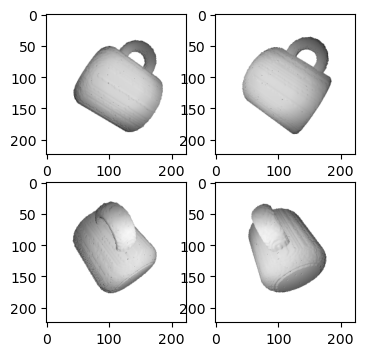

In [24]:
l_image_list = []
r_image_list = []

toy_data_path = '/home/guest/68301_Shared/toy_data'
for i in range(0, 2):
    test_data = np.load(osp.join(toy_data_path, '1a97f3c83016abca21d0de04f408950f', f'pose_{i}.npz'), allow_pickle=True)
    l_image_list.append(np.einsum('ijk->jki', test_data['l_image']).astype(int))
    r_image_list.append(np.einsum('ijk->jki', test_data['r_image']).astype(int))
    print(test_data['pose'])
plot_image_lists(l_image_list, r_image_list)

In [25]:
model = HdrnAlphaStereo()

for l_image, r_image in zip(l_image_list, r_image_list):
    

TypeError: __init__() missing 1 required positional argument: 'hparams'